In [ ]:
from collections import OrderedDict
import glob
import itertools
import json
import random
from typing import List

from potoo.plot import *
from potoo.util import *
import sklearn.utils

import metadata
from cache import *
from constants import *
from features import *
from load import *
from sp14.skm import SKM
from util import *

figsize('inline_short')

{
  '_Rdefaults': '--width=12 --height=4.0 --units=in --res=144',
  '_figure_format': 'retina',
  'aspect_ratio': 0.3333333333333333,
  'dpi': 72,
  'width': 12,
}

In [ ]:
recs_paths = load_recs_paths([
    'peterson-field-guide',
    'recordings',
    'recordings-new',
])
display(
    recs_paths.shape,
    recs_paths.groupby('dataset').head(5),
    recs_paths.dataset.value_counts(),
)

(478, 2)

,dataset,path
0,recordings,"recordings/black phoebe, chirps, noise.wav"
1,recordings,"recordings/black phoebe, sitting and catching.wav"
2,recordings,recordings/caique purring.wav
3,recordings,recordings/cal towhee.wav
4,recordings,"recordings/chickadee funny noise, other chirp song sparrow.wav"
51,recordings-new,recordings-new/BEWR 20171007 Bewicks Wren (Coyote Hills parking lot).wav
52,recordings-new,recordings-new/BEWR 20171007 Bewicks Wren 2 (Coyote Hills parking lot) 2.wav
53,recordings-new,recordings-new/BEWR 20171007 Bewicks Wren 2 (Coyote Hills parking lot).wav
54,recordings-new,recordings-new/bg noise- ocean- wind- etc- Hwy 1 Mt Tam.wav
55,recordings-new,recordings-new/black throated gray- kings rd.wav


peterson-field-guide    341
recordings-new           86
recordings               51
Name: dataset, dtype: int64

In [ ]:
recs = load_recs_data(
    (recs_paths
        # .sample(1000)  # For faster dev
    ),
    # FIXME pickling AudioSegment's across processes makes this (1) slow and (2) super-linearly slow
    #   - TODO We want 'processes' par for converting audio to std .wav format and 'threads' par for loading from std
    #     .wav, so split the convert (metadata_only=True) + load (metadata_only=False) steps to separate these concerns
    # metadata_only=True, dask_opts=dict(scheduler='processes'),
    metadata_only=False, dask_opts=dict(scheduler='threads'),
)
display(
    recs.shape,
    recs[:20],
    recs[:1].T,
)

[                                                                                          ] | 0% Completed |  0.0s

[                                                                                          ] | 1% Completed |  0.1s

[#######                                                                                   ] | 8% Completed |  0.3s

[#########                                                                                 ] | 10% Completed |  0.4s

[################                                                                          ] | 18% Completed |  0.5s

[#####################                                                                     ] | 23% Completed |  0.6s

[###############################                                                           ] | 35% Completed |  0.7s

[##########################################                                                ] | 46% Completed |  0.8s

[###################################################                                       ] | 57% Completed |  1.0s

[############################################################                              ] | 67% Completed |  1.1s

[#######################################################################                   ] | 79% Completed |  1.2s

[##################################################################################        ] | 91% Completed |  1.3s

[##########################################################################################] | 100% Completed |  1.4s

(478, 10)

,dataset,name,species,species_query,basename,duration_s,samples_mb,samples_n,samples,audio
0,recordings,"recordings/black phoebe, chirps, noise",XXXX,None,"black phoebe, chirps, noise",32.9,1.380,725569,[1389 2293 2172 ... 24 80 47],"recordings/black phoebe, chirps, noise: 1 channels, 16 bit, sampled @ 22.05 kHz, 32.906s long"
1,recordings,"recordings/black phoebe, sitting and catching",XXXX,None,"black phoebe, sitting and catching",83.3,3.500,1835765,[-74 -37 -2 ... 180 142 147],"recordings/black phoebe, sitting and catching: 1 channels, 16 bit, sampled @ 22.05 kHz, 83.255s long"
2,recordings,recordings/caique purring,XXXX,None,caique purring,48.8,2.050,1075070,[-192 -313 -295 ... -477 -545 -550],"recordings/caique purring: 1 channels, 16 bit, sampled @ 22.05 kHz, 48.756s long"
3,recordings,recordings/cal towhee,XXXX,None,cal towhee,43.2,1.820,951746,[ 291 405 386 ... -425 -271 -236],"recordings/cal towhee: 1 channels, 16 bit, sampled @ 22.05 kHz, 43.163s long"
4,recordings,"recordings/chickadee funny noise, other chirp song sparrow",XXXX,None,"chickadee funny noise, other chirp song sparrow",81.7,3.430,1800915,[ 75 166 191 ... -57 -89 -84],"recordings/chickadee funny noise, other chirp song sparrow: 1 channels, 16 bit, sampled @ 22.05 kHz, 81.674s long"
5,recordings,recordings/chipping sparrow?,XXXX,None,chipping sparrow?,27.5,1.160,606472,[ 208 149 141 ... -217 -157 -289],"recordings/chipping sparrow?: 1 channels, 16 bit, sampled @ 22.05 kHz, 27.504s long"
6,recordings,"recordings/common tellowthroat?, noise",XXXX,None,"common tellowthroat?, noise",63.0,2.650,1389150,[ 56 39 45 ... -43 91 107],"recordings/common tellowthroat?, noise: 1 channels, 16 bit, sampled @ 22.05 kHz, 63.000s long"
7,recordings,"recordings/crow, not phoebe, hummingbird",XXXX,None,"crow, not phoebe, hummingbird",86.7,3.650,1912824,[-4712 -5258 -4887 ... -553 -604 -413],"recordings/crow, not phoebe, hummingbird: 1 channels, 16 bit, sampled @ 22.05 kHz, 86.749s long"
8,recordings,"recordings/feeder: chickadee, various chips",XXXX,None,"feeder: chickadee, various chips",122.0,5.120,2684720,[ 46 92 118 ... 81 41 73],"recordings/feeder: chickadee, various chips: 1 channels, 16 bit, sampled @ 22.05 kHz, 121.756s long"
9,recordings,"recordings/feeder: lots of chips, some palm tree, chickadees, maybe bush tits, maybe sparrows",XXXX,None,"feeder: lots of chips, some palm tree, chickadees, maybe bush tits, maybe sparrows",110.0,4.610,2417062,[-406 -668 -656 ... 300 285 356],"recordings/feeder: lots of chips, some palm tree, chickadees, maybe bush tits, maybe sparrows: 1 channels, 16 bit, sampled @ 22.05 kHz, 109.617s long"


,0
dataset,recordings
name,"recordings/black phoebe, chirps, noise"
species,XXXX
species_query,None
basename,"black phoebe, chirps, noise"
duration_s,32.9
samples_mb,1.38
samples_n,725569
samples,[1389 2293 2172 ... 24 80 47]
audio,"recordings/black phoebe, chirps, noise: 1 channels, 16 bit, sampled @ 22.05 kHz, 32.906s long"


In [ ]:
# Names for easier dev (better autocomplete)
rec0 = recs[lambda df: df.species == 'WIWA'].iloc[1]
audio0 = rec0.audio

In [ ]:
# Manually step through featurize
rec_or_audio_or_signal = rec0
(rec, audio, x, sample_rate) = unpack_rec(rec_or_audio_or_signal)

spectro_f_min = 1000
spectro_f_bins = 40
spectro_hop_length = 256
spectro_frame_length = 512
spectro_frame_window = 'hann'
patch_length = 4
proj_skm_pca_var = .99
proj_skm_k = 500
agg_funs = ['mean', 'std', 'max']

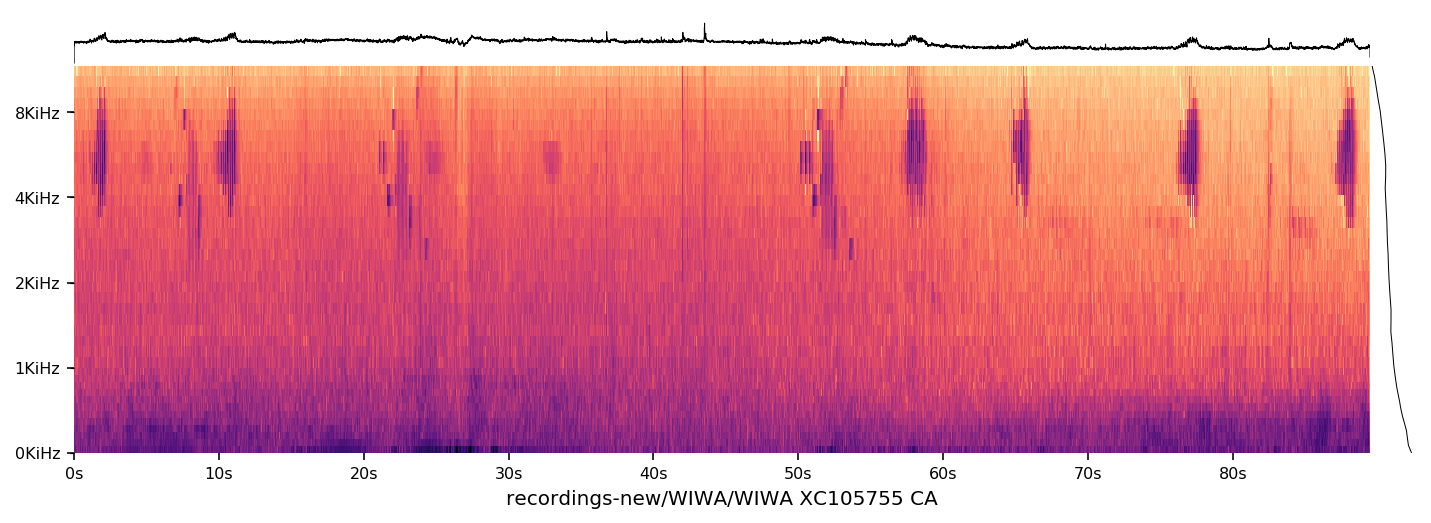

In [ ]:
# Spectro(audio_prefix).plot(fancy=False); plt.show()
# Melspectro(audio_prefix).plot(fancy=False); plt.show()
spectro = Melspectro(
    rec_or_audio_or_signal,
    nperseg=spectro_frame_length,
    overlap=1 - spectro_hop_length / spectro_frame_length,
    window=spectro_frame_window,
    n_mels=spectro_f_bins,
)
spectro.plot(show_audio=False)
plt.show()

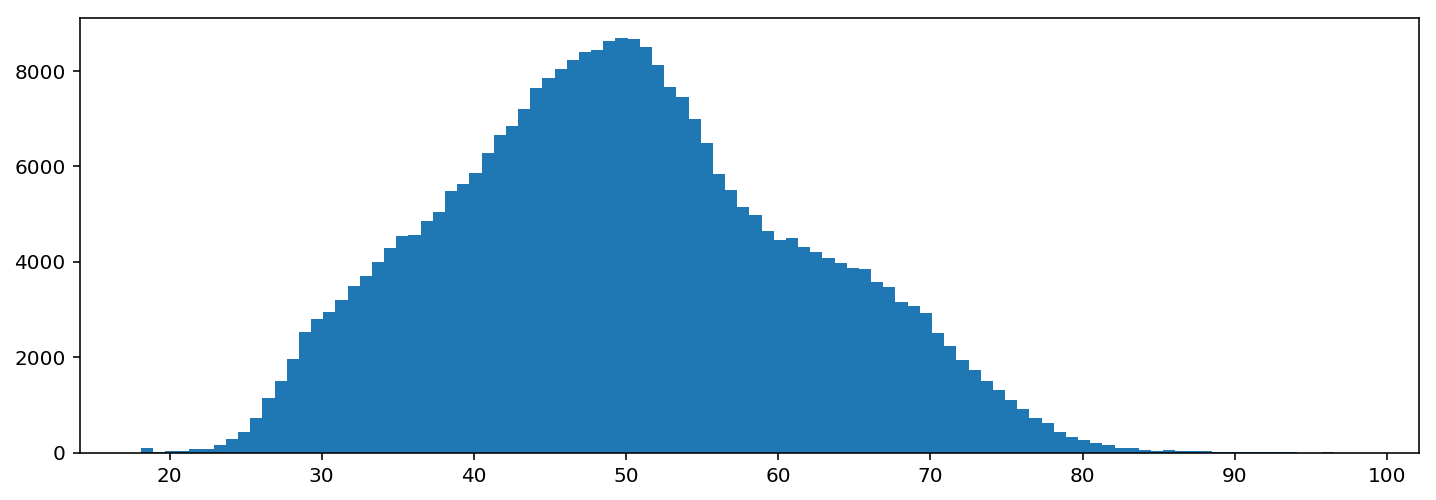

In [ ]:
# TODO Normalize so that S values (log powers) are comparable across recordings
#   - RMS [SP14]
#   - Median-based thresholding [SP14]
#   - ? [SBF16]
(f, t, S) = spectro
plt.hist(S.flatten(), bins=100); plt.show()

In [ ]:
# Train
from sp14.model import *
model = Model(verbose_config=True)

train_n, test_n = 10, 20
recs_shuf = sklearn.utils.shuffle(recs[lambda df: df.species != unk_species], random_state=0)
[recs_train, recs_test, *_] = np.split(recs_shuf, [train_n, train_n + test_n], axis=0)

[02:20:05.279] init:params
  rec_sample_rate: 22050 Hz
  spectro_f_min: 1000 Hz
    f_max: 11025 Hz
  spectro_f_bins (f): 40 freq bins
  spectro_hop_length: 256 samples (11.6 ms)
  spectro_frame_length: 512 samples (23.2 ms)
    frame_overlap: 50% overlap (256 samples)
    frames/s (t/s): 86.1 samples/s
  spectro_frame_window: '''hann'''
  norm: '[TODO]'
  patch_length (p): 4 frames (46.4 ms)
  proj_skm_variance_explained: 99% variance
  proj_skm_k: 500 clusters
  agg_funs: ('mean', 'std', 'max')
    a: 3 aggs
    features: 1500 features
  class_knn_n_neighbors: 3
[02:20:05.282] init:pipeline
  spectro: (f, t)   (40, 86.1/s)
  patch  : (f*p, t) (40*4, 86.1/s)
  proj   : (k, t)   (500, 86.1/s)
  agg    : (k, a)   (500, 3)
  feat   : (k*a,)   (1500,)


In [ ]:
model.fit_proj(recs_train);
model.fit_class(recs_train);

[02:20:05.317] patches:recs
  len(recs): 10
  duration_s: [17.449795918367347, 23.32734693877551, 21.812244897959182, 22.33469387755102, 39.83673469387755, 4.153469387755102, 34.27265306122449, 21.524897959183672, 13.348571428571429, 22.360816326530614]
  sum(duration_s): 220.42122448979595
  (samples,): [384768, 514368, 480960, 492480, 878400, 91584, 755712, 474624, 294336, 493056]
  sum(samples): 4860288
[Memory]216.7s, 3.6min  : Loading _patches_from_recs from /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_patches_from_recs/cf930a5a5b6778f58fb04da5dd46f699
___________________________________patches_from_recs cache loaded - 0.0s, 0.0min
[02:20:05.389] patches:patches
  (f*p, t): [[160, 1499], [160, 2005], [160, 1874], [160, 1919], [160, 3427], [160, 353], [160, 2948], [160, 1850], [160, 1145], [160, 1922]]
  (f*p, sum(t)): [160, 18942]
[02:20:05.405] fit_proj:skm_X
  skm_X.shape: [160, 18942]
[Memory]216.7s, 3.6min  : Loading _skm_fit from /Users/danb/hack/bubo/data/cache/joblib

[Memory]216.8s, 3.6min  : Loading _patches_from_recs from /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_patches_from_recs/cf930a5a5b6778f58fb04da5dd46f699
___________________________________patches_from_recs cache loaded - 0.0s, 0.0min
[02:20:05.512] patches:patches
  (f*p, t): [[160, 1499], [160, 2005], [160, 1874], [160, 1919], [160, 3427], [160, 353], [160, 2948], [160, 1850], [160, 1145], [160, 1922]]
  (f*p, sum(t)): [160, 18942]
[02:20:05.520] [SKM] transform
[02:20:05.520] [SKM] _pca_transform


[02:20:05.696] fit_class:knn_Xy
  (f*p, t): [[160, 1499], [160, 2005], [160, 1874], [160, 1919], [160, 3427], [160, 353], [160, 2948], [160, 1850], [160, 1145], [160, 1922]]
[02:20:05.700] fit_class:knn
  knn.get_params: {algorithm: auto, leaf_size: 30, metric: minkowski, metric_params: null, n_jobs: 1, n_neighbors: 3, p: 2, weights: uniform}
  knn.classes_: [BEWR, BOCH, CANW, CARW, MAWR, SEWR, TUTI, WBNU, WCSP]


In [ ]:
# Test

In [ ]:
model.test(recs_test, 'classes')

[02:20:05.779] patches:recs
  len(recs): 20
  duration_s: [49.136326530612244, 20.218775510204082, 29.544489795918366, 21.995102040816327, 23.092244897959183, 17.711020408163265, 7.444897959183673, 29.910204081632653, 27.036734693877552, 18.05061224489796, 30.119183673469387, 3.5526530612244898, 19.33061224489796, 20.166530612244898, 21.995102040816327, 89.49600907029479, 63.89551020408163, 21.76, 13.035102040816327, 14.236734693877551]
  sum(duration_s): 541.7278458049888
  (samples,): [1083456, 445824, 651456, 484992, 509184, 390528, 164160, 659520, 596160, 398016, 664128, 78336, 426240, 444672, 484992, 1973387, 1408896, 479808, 287424, 313920]
  sum(samples): 11945099
[Memory]217.2s, 3.6min  : Loading _patches_from_recs from /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_patches_from_recs/d5012b9973081d1e01ce4ce7ecb426c9


___________________________________patches_from_recs cache loaded - 0.0s, 0.0min
[02:20:05.926] patches:patches
  (f*p, t): [[160, 4228], [160, 1737], [160, 2540], [160, 1890], [160, 1985], [160, 1521], [160, 637], [160, 2572], [160, 2324], [160, 1550], [160, 2590], [160, 302], [160, 1661], [160, 1733], [160, 1890], [160, 7704], [160, 5499], [160, 1870], [160, 1118], [160, 1222]]
  (f*p, sum(t)): [160, 46573]
[02:20:05.942] [SKM] transform
[02:20:05.942] [SKM] _pca_transform


[02:20:06.368] predict:classes


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
y,BEWR,WCSP,SOSP,WIWA,WCSP,MAWR,CACW,BCCH,CACW,CACH,TUTI,CANW,BEWR,WIWR,TUTI,WIWA,WIWR,TUTI,BUSH,BEWR
0,"[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BOCH]","[0.333, BEWR]","[0.333, BEWR]","[0.333, BEWR]"
1,"[0.333, CANW]","[0.333, CARW]","[0.333, BOCH]","[0.333, CARW]","[0.333, CANW]","[0.333, CARW]","[0.333, CARW]","[0.333, CARW]","[0.333, CARW]","[0.333, CARW]","[0.333, CARW]","[0.333, CARW]","[0.333, CARW]","[0.333, CARW]","[0.333, CARW]","[0.333, CARW]","[0.333, CANW]","[0.333, CARW]","[0.333, TUTI]","[0.333, CARW]"
2,"[0.333, WCSP]","[0.333, WCSP]","[0.333, CARW]","[0.333, SEWR]","[0.333, CARW]","[0.333, WCSP]","[0.333, WCSP]","[0.333, WCSP]","[0.333, WCSP]","[0.333, WCSP]","[0.333, WCSP]","[0.333, WCSP]","[0.333, WCSP]","[0.333, WCSP]","[0.333, WCSP]","[0.333, WCSP]","[0.333, CARW]","[0.333, WCSP]","[0.333, WCSP]","[0.333, WCSP]"
3,"[0.0, BOCH]","[0.0, BOCH]","[0.0, CANW]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BEWR]","[0.0, BOCH]","[0.0, BOCH]","[0.0, BOCH]"
4,"[0.0, CARW]","[0.0, CANW]","[0.0, MAWR]","[0.0, CANW]","[0.0, MAWR]","[0.0, CANW]","[0.0, CANW]","[0.0, CANW]","[0.0, CANW]","[0.0, CANW]","[0.0, CANW]","[0.0, CANW]","[0.0, CANW]","[0.0, CANW]","[0.0, CANW]","[0.0, CANW]","[0.0, MAWR]","[0.0, CANW]","[0.0, CANW]","[0.0, CANW]"
5,"[0.0, MAWR]","[0.0, MAWR]","[0.0, SEWR]","[0.0, MAWR]","[0.0, SEWR]","[0.0, MAWR]","[0.0, MAWR]","[0.0, MAWR]","[0.0, MAWR]","[0.0, MAWR]","[0.0, MAWR]","[0.0, MAWR]","[0.0, MAWR]","[0.0, MAWR]","[0.0, MAWR]","[0.0, MAWR]","[0.0, SEWR]","[0.0, MAWR]","[0.0, CARW]","[0.0, MAWR]"
6,"[0.0, SEWR]","[0.0, SEWR]","[0.0, TUTI]","[0.0, TUTI]","[0.0, TUTI]","[0.0, SEWR]","[0.0, SEWR]","[0.0, SEWR]","[0.0, SEWR]","[0.0, SEWR]","[0.0, SEWR]","[0.0, SEWR]","[0.0, SEWR]","[0.0, SEWR]","[0.0, SEWR]","[0.0, SEWR]","[0.0, TUTI]","[0.0, SEWR]","[0.0, MAWR]","[0.0, SEWR]"
7,"[0.0, TUTI]","[0.0, TUTI]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]","[0.0, TUTI]","[0.0, TUTI]","[0.0, TUTI]","[0.0, TUTI]","[0.0, TUTI]","[0.0, TUTI]","[0.0, TUTI]","[0.0, TUTI]","[0.0, TUTI]","[0.0, TUTI]","[0.0, TUTI]","[0.0, WBNU]","[0.0, TUTI]","[0.0, SEWR]","[0.0, TUTI]"
8,"[0.0, WBNU]","[0.0, WBNU]","[0.0, WCSP]","[0.0, WCSP]","[0.0, WCSP]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WCSP]","[0.0, WBNU]","[0.0, WBNU]","[0.0, WBNU]"


In [ ]:
model.test(recs_test, 'kneighbors')

[02:20:06.496] patches:recs
  len(recs): 20
  duration_s: [49.136326530612244, 20.218775510204082, 29.544489795918366, 21.995102040816327, 23.092244897959183, 17.711020408163265, 7.444897959183673, 29.910204081632653, 27.036734693877552, 18.05061224489796, 30.119183673469387, 3.5526530612244898, 19.33061224489796, 20.166530612244898, 21.995102040816327, 89.49600907029479, 63.89551020408163, 21.76, 13.035102040816327, 14.236734693877551]
  sum(duration_s): 541.7278458049888
  (samples,): [1083456, 445824, 651456, 484992, 509184, 390528, 164160, 659520, 596160, 398016, 664128, 78336, 426240, 444672, 484992, 1973387, 1408896, 479808, 287424, 313920]
  sum(samples): 11945099


[Memory]217.9s, 3.6min  : Loading _patches_from_recs from /Users/danb/hack/bubo/data/cache/joblib/sp14/model/_patches_from_recs/d5012b9973081d1e01ce4ce7ecb426c9
___________________________________patches_from_recs cache loaded - 0.0s, 0.0min
[02:20:06.640] patches:patches
  (f*p, t): [[160, 4228], [160, 1737], [160, 2540], [160, 1890], [160, 1985], [160, 1521], [160, 637], [160, 2572], [160, 2324], [160, 1550], [160, 2590], [160, 302], [160, 1661], [160, 1733], [160, 1890], [160, 7704], [160, 5499], [160, 1870], [160, 1118], [160, 1222]]
  (f*p, sum(t)): [160, 46573]
[02:20:06.673] [SKM] transform
[02:20:06.673] [SKM] _pca_transform


[02:20:07.110] predict:kneighbors


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
y,BEWR,WCSP,SOSP,WIWA,WCSP,MAWR,CACW,BCCH,CACW,CACH,TUTI,CANW,BEWR,WIWR,TUTI,WIWA,WIWR,TUTI,BUSH,BEWR
0,"[2, 61.0, BEWR]","[5, 43.3, WCSP]","[2, 60.4, BEWR]","[1, 44.8, SEWR]","[2, 56.1, BEWR]","[2, 42.4, BEWR]","[8, 53.4, CARW]","[5, 43.3, WCSP]","[2, 49.9, BEWR]","[2, 50.2, BEWR]","[8, 44.3, CARW]","[5, 41.4, WCSP]","[2, 35.8, BEWR]","[2, 40.8, BEWR]","[2, 55.7, BEWR]","[5, 47.4, WCSP]","[3, 80.1, CANW]","[2, 52.7, BEWR]","[4, 42.6, TUTI]","[2, 38.8, BEWR]"
1,"[3, 63.7, CANW]","[2, 46.7, BEWR]","[0, 61.1, BOCH]","[8, 53.0, CARW]","[3, 60.0, CANW]","[5, 43.9, WCSP]","[5, 56.8, WCSP]","[2, 44.6, BEWR]","[8, 50.6, CARW]","[5, 50.4, WCSP]","[2, 53.2, BEWR]","[2, 47.2, BEWR]","[8, 37.4, CARW]","[8, 45.6, CARW]","[5, 59.4, WCSP]","[2, 52.2, BEWR]","[0, 81.7, BOCH]","[5, 54.5, WCSP]","[5, 45.2, WCSP]","[8, 40.5, CARW]"
2,"[5, 63.9, WCSP]","[8, 49.8, CARW]","[8, 65.0, CARW]","[2, 57.2, BEWR]","[8, 61.1, CARW]","[8, 50.1, CARW]","[2, 57.4, BEWR]","[8, 49.7, CARW]","[5, 54.9, WCSP]","[8, 50.9, CARW]","[5, 53.3, WCSP]","[8, 55.8, CARW]","[5, 44.4, WCSP]","[5, 49.2, WCSP]","[8, 63.2, CARW]","[8, 57.3, CARW]","[8, 89.8, CARW]","[8, 61.6, CARW]","[2, 49.9, BEWR]","[5, 47.0, WCSP]"
3,"[0, 64.7, BOCH]","[1, 51.8, SEWR]","[5, 65.6, WCSP]","[5, 59.0, WCSP]","[5, 65.9, WCSP]","[1, 57.4, SEWR]","[4, 62.1, TUTI]","[4, 57.0, TUTI]","[9, 62.3, WBNU]","[4, 62.1, TUTI]","[4, 56.7, TUTI]","[1, 59.9, SEWR]","[4, 57.1, TUTI]","[1, 49.7, SEWR]","[4, 65.9, TUTI]","[1, 58.6, SEWR]","[2, 89.9, BEWR]","[4, 63.4, TUTI]","[8, 52.8, CARW]","[1, 55.6, SEWR]"
4,"[8, 68.9, CARW]","[4, 59.7, TUTI]","[1, 69.9, SEWR]","[0, 66.2, BOCH]","[1, 72.2, SEWR]","[4, 63.2, TUTI]","[1, 65.8, SEWR]","[1, 58.1, SEWR]","[7, 62.3, WBNU]","[1, 62.7, SEWR]","[7, 60.9, WBNU]","[4, 61.0, TUTI]","[1, 57.2, SEWR]","[0, 58.5, BOCH]","[7, 71.5, WBNU]","[4, 60.6, TUTI]","[1, 93.0, SEWR]","[7, 67.9, WBNU]","[1, 53.4, SEWR]","[4, 62.4, TUTI]"
5,"[1, 73.8, SEWR]","[0, 68.4, BOCH]","[3, 72.8, CANW]","[4, 71.0, TUTI]","[0, 77.7, BOCH]","[7, 63.4, WBNU]","[9, 66.9, WBNU]","[7, 68.0, WBNU]","[1, 63.7, SEWR]","[0, 67.1, BOCH]","[1, 64.4, SEWR]","[7, 65.3, WBNU]","[7, 63.1, WBNU]","[4, 59.7, TUTI]","[0, 73.1, BOCH]","[0, 67.4, BOCH]","[5, 94.2, WCSP]","[0, 71.9, BOCH]","[0, 66.0, BOCH]","[7, 65.9, WBNU]"
6,"[4, 74.4, TUTI]","[3, 69.9, CANW]","[4, 74.0, TUTI]","[3, 75.2, CANW]","[7, 83.8, WBNU]","[0, 65.4, BOCH]","[7, 67.9, WBNU]","[3, 68.5, CANW]","[4, 64.0, TUTI]","[7, 70.9, WBNU]","[9, 68.9, WBNU]","[9, 74.6, WBNU]","[0, 70.9, BOCH]","[7, 71.0, WBNU]","[1, 76.7, SEWR]","[7, 72.6, WBNU]","[6, 100.0, MAWR]","[1, 77.2, SEWR]","[7, 72.9, WBNU]","[9, 69.2, WBNU]"
7,"[7, 82.0, WBNU]","[7, 71.4, WBNU]","[7, 81.9, WBNU]","[7, 76.1, WBNU]","[9, 85.1, WBNU]","[9, 67.2, WBNU]","[0, 83.7, BOCH]","[0, 73.0, BOCH]","[0, 65.6, BOCH]","[3, 71.0, CANW]","[0, 78.2, BOCH]","[3, 77.5, CANW]","[9, 71.0, WBNU]","[3, 73.3, CANW]","[3, 79.6, CANW]","[3, 73.6, CANW]","[4, 101.0, TUTI]","[9, 78.4, WBNU]","[3, 80.1, CANW]","[0, 69.3, BOCH]"
8,"[6, 85.3, MAWR]","[9, 78.6, WBNU]","[9, 92.2, WBNU]","[9, 87.0, WBNU]","[4, 85.9, TUTI]","[3, 69.5, CANW]","[3, 89.6, CANW]","[9, 74.6, WBNU]","[3, 79.9, CANW]","[9, 77.6, WBNU]","[3, 87.4, CANW]","[0, 78.9, BOCH]","[3, 73.3, CANW]","[9, 76.3, WBNU]","[9, 79.7, WBNU]","[9, 85.2, WBNU]","[7, 112.0, WBNU]","[3, 78.5, CANW]","[9, 80.9, WBNU]","[3, 73.2, CANW]"
